In [2]:
import stageemi.dev.decorator_map as dm
import xarray as xr 
import ipywidgets as widg
import ipyleaflet as ipyl
import datetime as dt
import os 
import numpy as np
import shapely
from stageemi.dev.visu import Borders,Map
import geojson
from ipyleaflet import WidgetControl
import pandas 


In [3]:
var2plot = "FF"
mask = 'FRJ13' #['FRB05',"FRH02",'FRJ13','FRK24']
dir_in = '/scratch/labia/lepapeb/StageEMI/'+var2plot+'/'

fname  = dir_in + '20200122060000__PAROME__FF__EURW1S100______GRILLE____0_48_1__HAUTEUR__10__.nc'
ds = xr.open_dataset(fname)
ds['latitude']=ds['latitude'].round(5)
ds['longitude']=ds['longitude'].round(5)
print(fname)

/scratch/labia/lepapeb/StageEMI/FF/20200122060000__PAROME__FF__EURW1S100______GRILLE____0_48_1__HAUTEUR__10__.nc


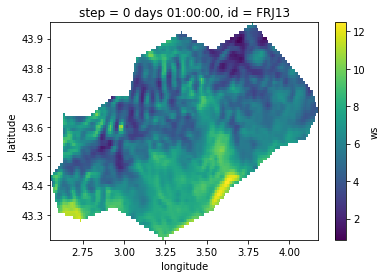

In [39]:

fname_mask = '/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/nc_departement/'+mask+'.nc'
ds_mask = xr.open_dataset(fname_mask)
ds_mask["latitude"]=ds_mask["latitude"].round(5)
ds_mask["longitude"]=ds_mask["longitude"].round(5)
lat_center = ds_mask["latitude"].values.mean()
lon_center = ds_mask["longitude"].values.mean()

ds_b = ds*ds_mask["mask"]
ds_b = ds_b.squeeze("id")    


ds_b['ws'].isel(step=1).plot.imshow()

In [36]:
@dm.gogeojson()
def get_step(step):
    return ds_b["ws"].isel(step=step)

def update_html(feature, **kwargs):
    #print(feature['properties'])
    html1.value = '''
        <h4> Vitesse </h4>
        <h4><b>{}</b></h4>
    '''.format(feature['properties']['message'])
    
   # html1.value = '''
    #    <h4> Type de temps </h4>
     #   <h4><b>{}</b></h4>
    #'''.format(feature['properties']['value'])
    
def on_change(change):
    geo_file,legend_file = get_step(change["new"])
    geojson_layer = ipyl.GeoJSON(data=geo_file,hover_style={"opacity":1})
    if len(m.layers) == 1:
        m.add_layer(geojson_layer)
    else: 
        m.substitute_layer(m.layers[1],geojson_layer)
    geojson_layer.on_hover(update_html)
    legend_file.seek(0)
    legend.value =legend_file.read() 
    
slider = widg.IntSlider(min=0,max=len(ds_b.step),step=1,value=0,description="step")
slider.observe(on_change,'value')
    
    

In [15]:
np.around(2.555555558888999,2)

2.56

In [37]:
m = ipyl.Map(zoom=9, center=(lat_center,lon_center ))
html1 = widg.HTML('''
    <h4>Vitesse</h4>
    Hover over a pixel
''')
html1.layout.margin = '0px 20px 20px 20px'
control1 = WidgetControl(widget=html1, position='bottomright')
m.add_control(control1)
m.add_control(ipyl.WidgetControl(widget=slider,position="topright"))
geo_file,legend_file = get_step(0)

geojson_layer = ipyl.GeoJSON(data=geo_file,hover_style={"opacity":1,"fillColor":"#000000"})
geojson_layer.on_hover(update_html)
m.add_layer(geojson_layer)

legend_file.seek(0)
legend = widg.Image(layout=widg.Layout(height="430px"))
legend.value = legend_file.read() 
widg_map = widg.HBox([m,legend])
widg_map